### Demo4 STARmap to MERFISH

In [1]:
import scanpy as sc
import torch,random,os,sys
from tqdm import tqdm
import numpy as np
import CAST
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_chunked

workdir = '$demo_path' #### input the demo path
output_path = f'{workdir}/demo4_STARmap_to_MERFISH/demo_output'
os.makedirs(output_path,exist_ok=True)
sdata = sc.read_h5ad(f'{workdir}/demo4_STARmap_to_MERFISH/data/STARmap_vs_MERFISH.h5ad')

Using backend: pytorch


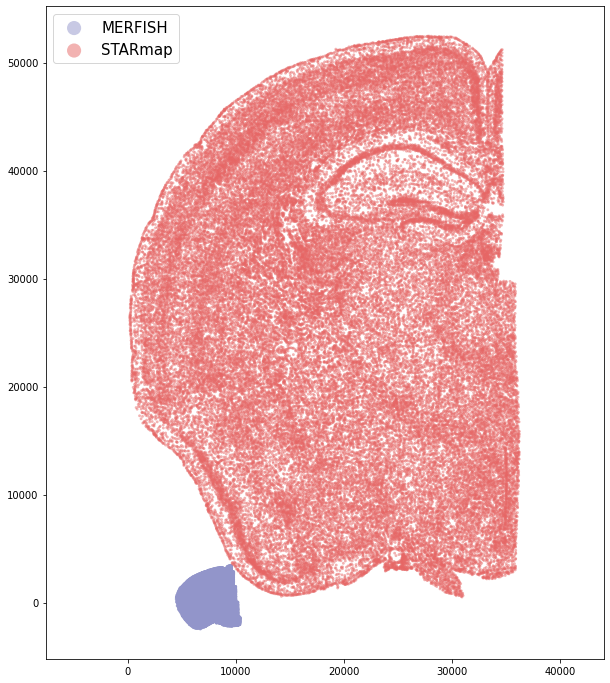

In [2]:
sample_list= ['STARmap','MERFISH']
batch_key = 'batch'
coords_t = np.array(sdata.obs[['center_x', 'center_y']])
CAST.plot_mid(coords_t[sdata.obs[batch_key] == sample_list[0]],
         coords_t[sdata.obs[batch_key] == sample_list[1]],
         output_path=output_path,
         filename = 'Align_raw',
         title_t = [sample_list[1],
                    sample_list[0]],
         s_t = 8,scale_bar_t = None)

In [3]:
coords_raw,exps = CAST.extract_coords_exp(sdata, batch_key = 'batch', cols = ['center_x', 'center_y'], count_layer = '.X', data_format = 'norm1e4')
coords_sub,exp_sub,sub_node_idxs = CAST.sub_data_extract(sample_list,coords_raw, exps, nodenum_t = 20000)
torch.save(coords_raw, f'{output_path}/coords_raw.pt')
torch.save(sub_node_idxs, f'{output_path}/sub_node_idxs.pt')
torch.save(exp_sub, f'{output_path}/exp_sub.pt')
torch.save(coords_sub, f'{output_path}/coords_sub.pt')

Preprocessing...


/home/unix/ztang/02.tools/miniconda3/envs/zefang/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Constructing delaunay graphs for 2 samples...
Training on cuda:0...


Loss: -435.143 step time=0.188s: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:16<00:00,  5.24it/s]


Finished.
The embedding, log, model files were saved to /home/unix/ztang/wanglab/tangzefang/03.Projects/05.CCF/06.warp_up_tutorials/01.data/demo4_STARmap_to_MERFISH/demo_output
Perform KMeans clustering on 40000 cells...
Plotting the KMeans clustering results...


array([18, 15, 16, ...,  8,  4, 11], dtype=int32)

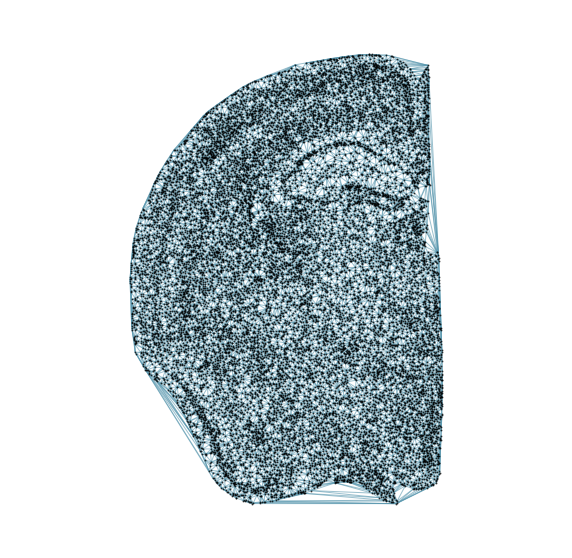

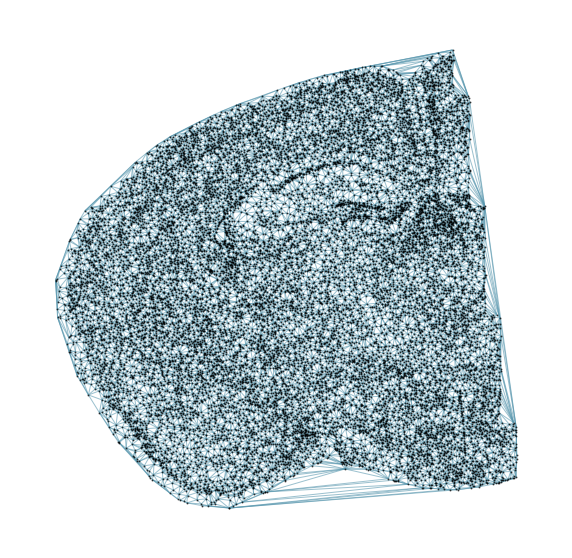

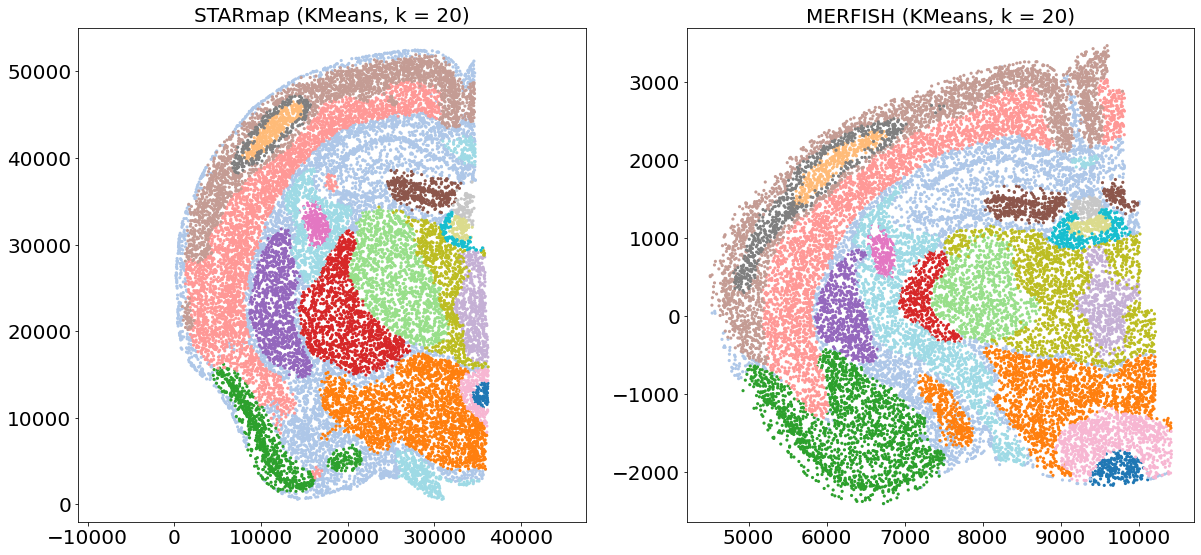

In [4]:
embed_dict = CAST.CAST_MARK(coords_sub,exp_sub,output_path,graph_strategy='delaunay')
CAST.kmeans_plot_multiple(embed_dict,sample_list,coords_sub,'demo1',output_path,k=20,dot_size = 10,minibatch=True)

In [5]:
coords_raw2 = coords_raw.copy()
for sample_t in sample_list:
    coords_raw2[sample_t] = coords_raw2[sample_t] / coords_raw2[sample_t].max() * 22340

Loss: 4166.345: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:21<00:00,  7.10it/s]
/home/unix/ztang/02.tools/miniconda3/envs/zefang/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 148.81it/s]


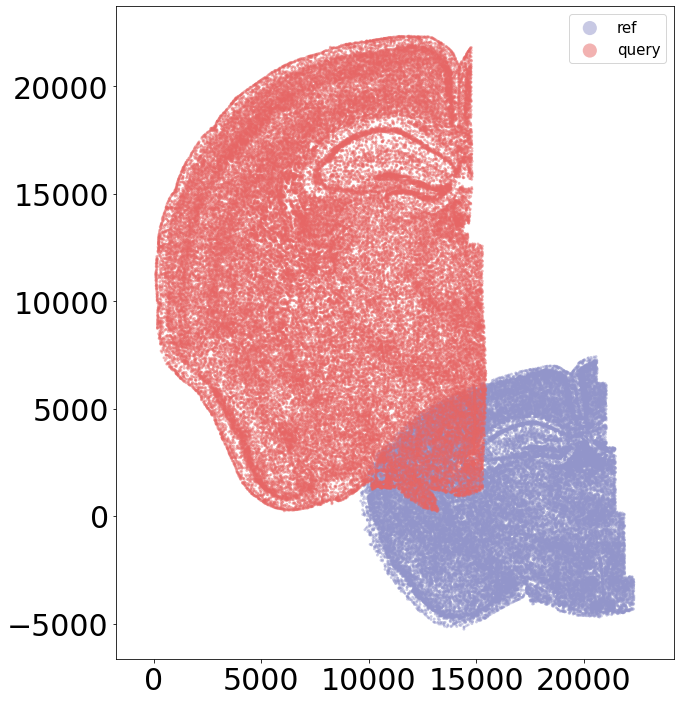

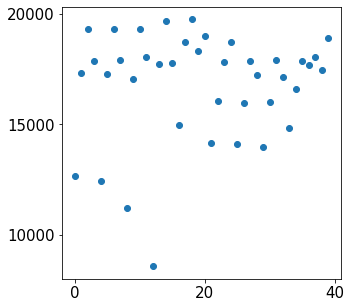

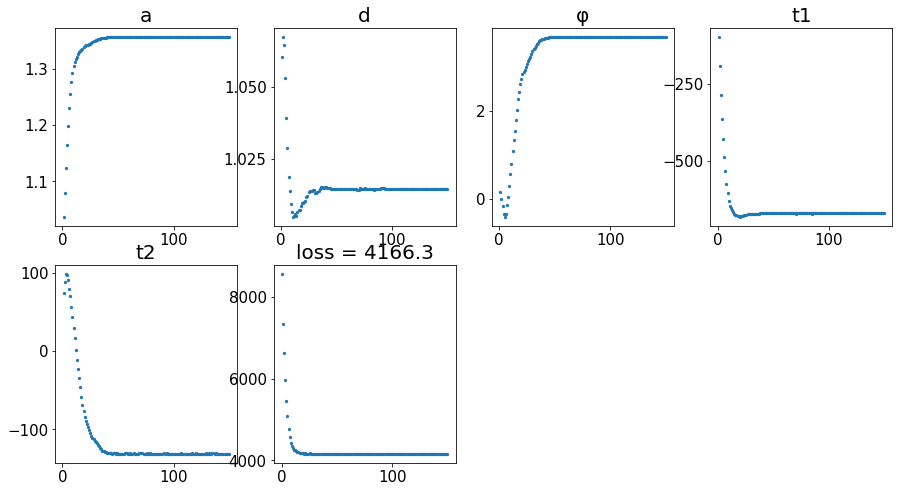

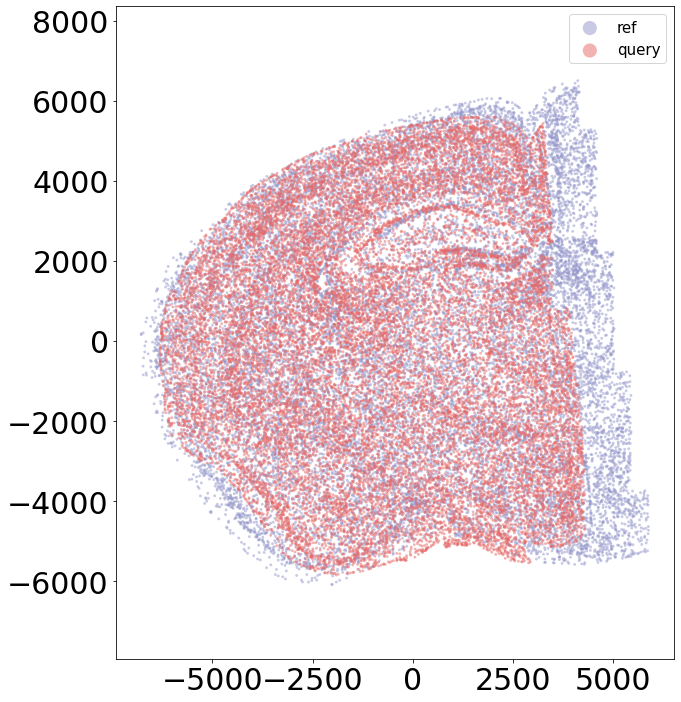

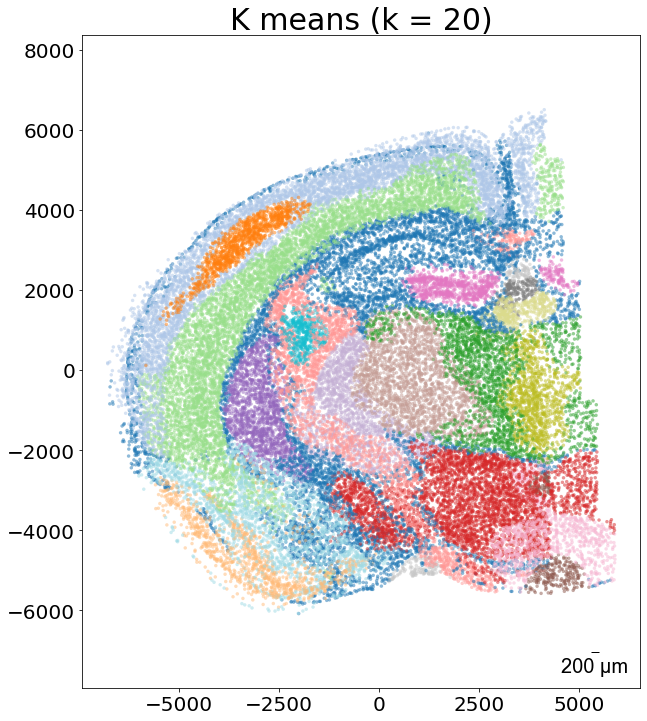

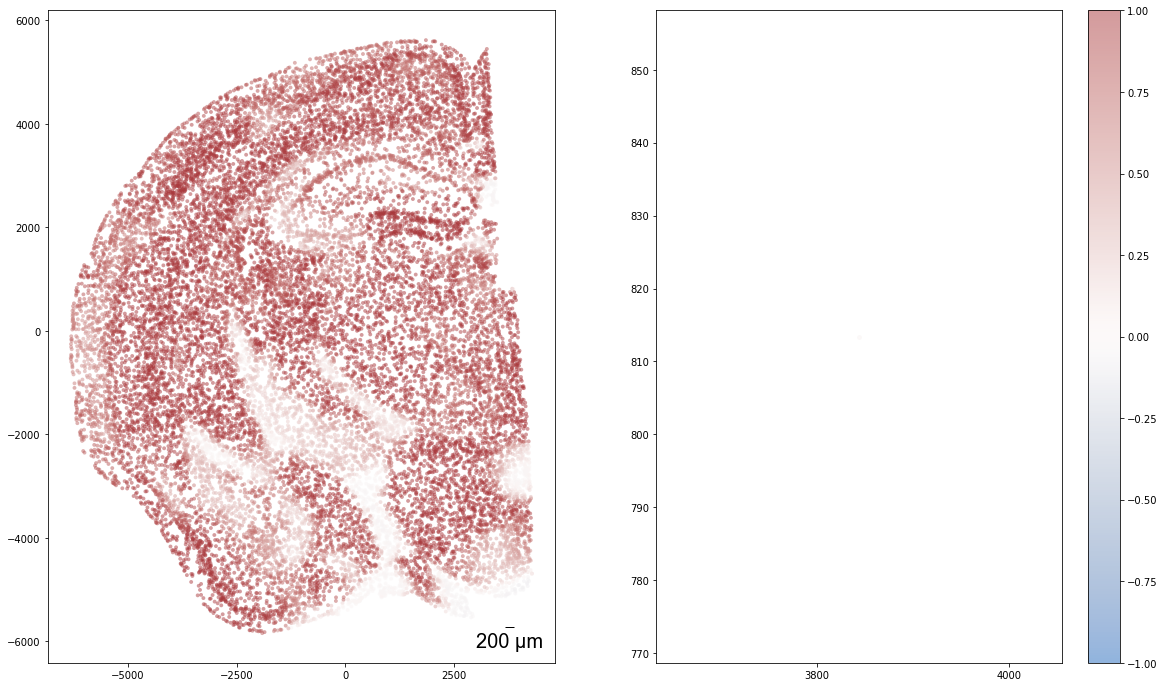

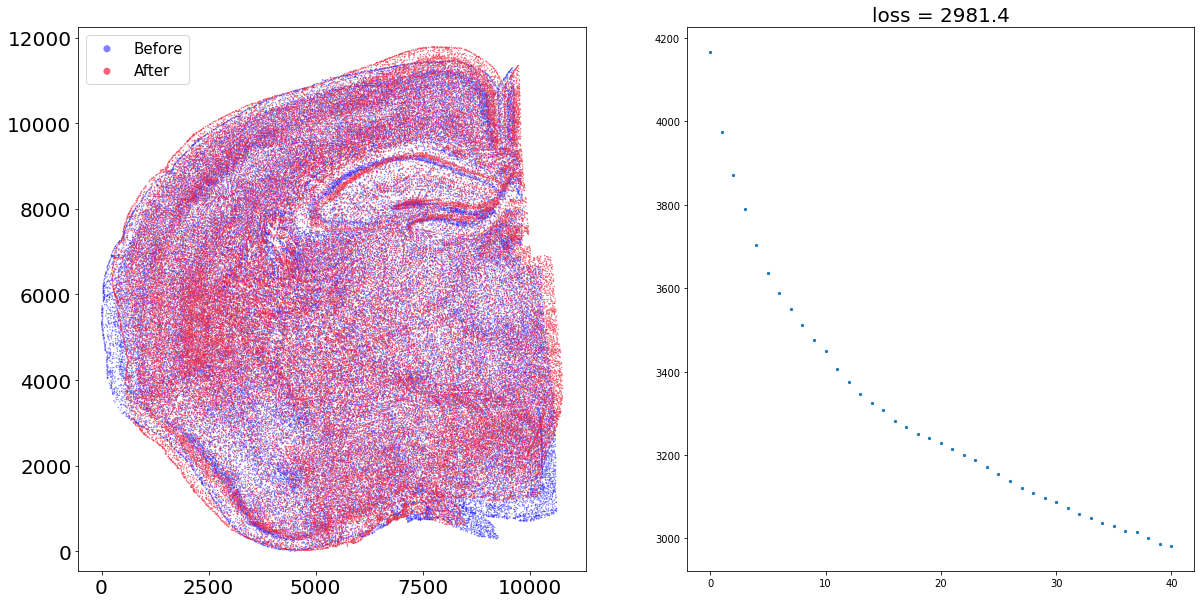

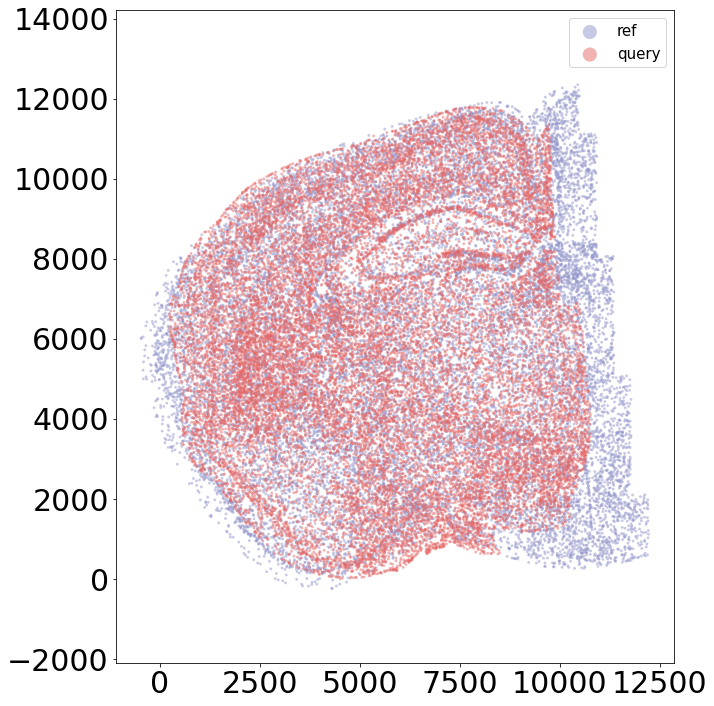

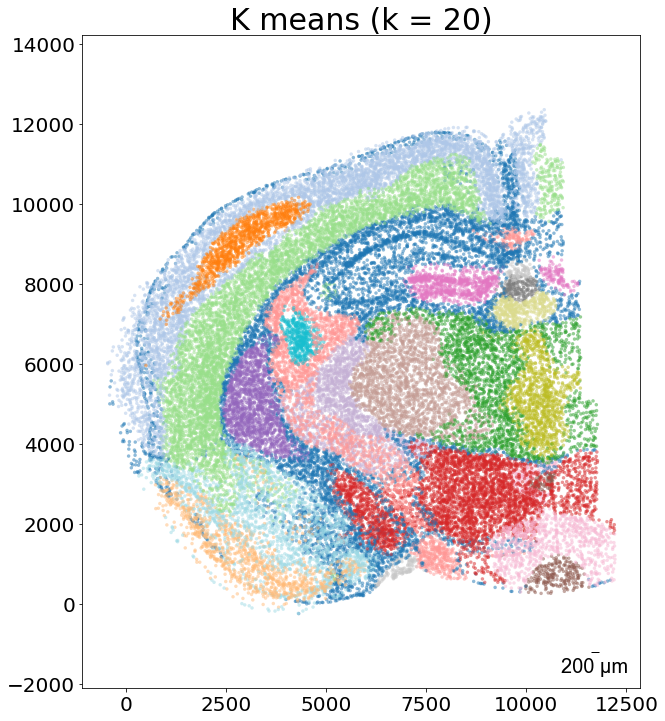

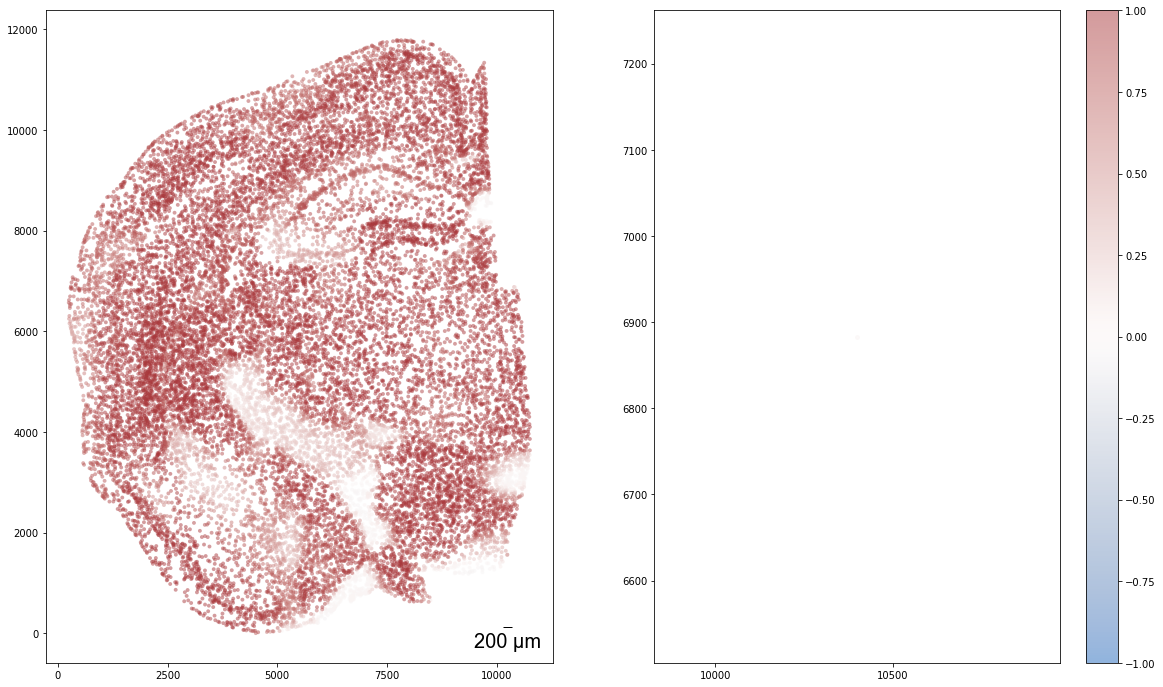

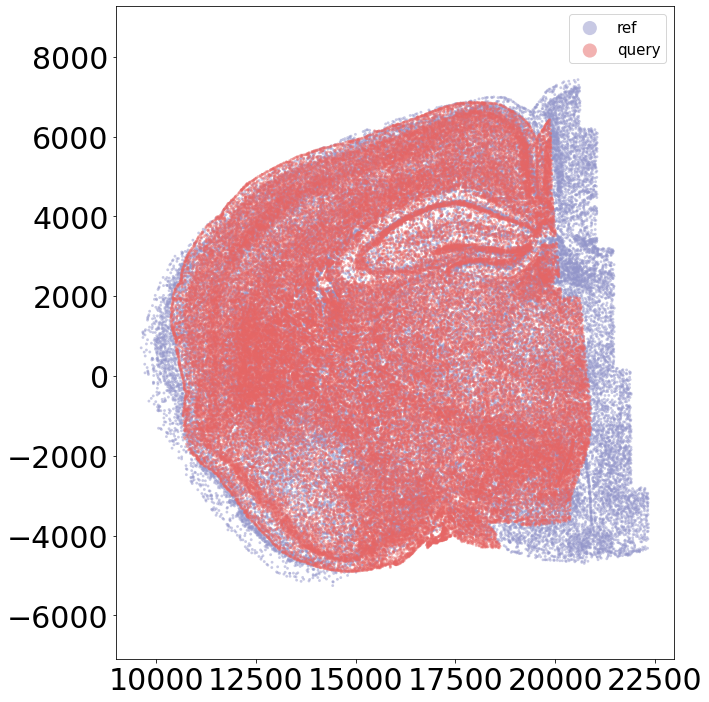

In [17]:
query_sample = sample_list[0]
params_dist = CAST.reg_params(dataname = query_sample,
                            gpu = 0 if torch.cuda.is_available() else -1, 
                            #### Affine parameters
                            iterations=150,
                            dist_penalty1=0,
                            bleeding=500,
                            d_list = [3,2,1,1/2,1/3],
                            attention_params = [None,3,1,0], 
                            #### FFD parameters    
                            dist_penalty2 = [0],
                            alpha_basis_bs = [500],
                            meshsize = [8],
                            iterations_bs = [40],
                            attention_params_bs = [[None,3,1,0]],
                            mesh_weight = [None])
params_dist.alpha_basis = torch.Tensor([1/1000,1/1000,1/50,5,5]).reshape(5,1).to(params_dist.device)
coord_final = CAST.CAST_STACK(coords_raw2,embed_dict,output_path,sample_list,params_dist,sub_node_idxs = sub_node_idxs) # v3.0

Perform KMeans clustering on 40000 cells...
Plotting the KMeans clustering results...


array([18, 15, 16, ...,  8,  4, 11], dtype=int32)

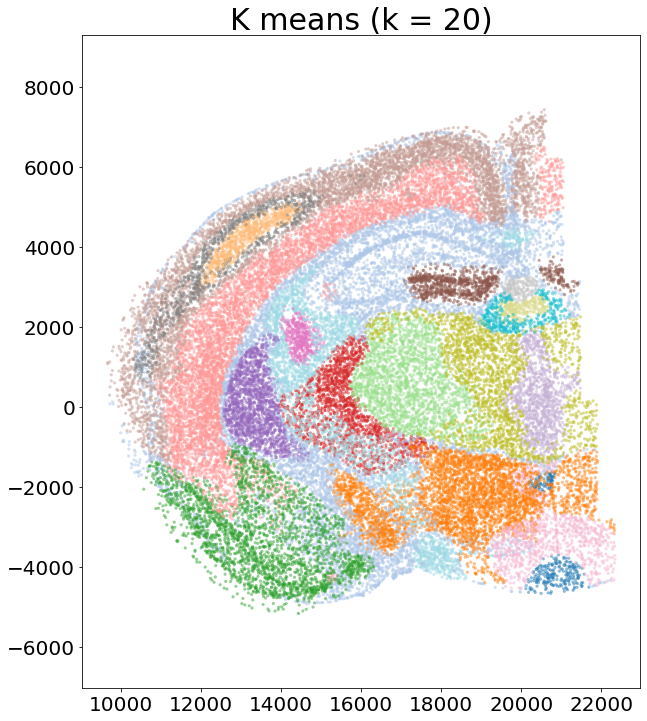

In [20]:
coord_final = torch.load(f'{output_path}/STARmap_align_to_MERFISH_coords_final.data')

sample_list= ['STARmap','MERFISH']
embed_dict = torch.load(f'{output_path}/demo_embed_dict.pt',map_location='cpu')
sub_node_idxs = torch.load(f'{output_path}/sub_node_idxs.pt')

coords_sub_new = dict()
for sample_t in sample_list:
    coords_sub_new[sample_t] = coord_final[sample_t][sub_node_idxs[sample_t],:]
CAST.kmeans_plot_multiple(embed_dict,sample_list,coords_sub_new,'demo1_new',output_path,k=20,dot_size = 10,minibatch=True,plot_strategy='stack')